In [1]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(viridis)
source("./ptime.fun.R")
source("./enrich.fun.R")

inputdir <- "./load_files/"


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

Loading required package: Matrix

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor


circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

Thi

In [2]:
## Load data
load(file = paste0(inputdir, "Pseudobulk_by_region.Rdata")) 
#avgs, pmeta, rgc_cbn; Only rgc_cbn is used
rm_cells <- rownames(rgc_cbn@meta.data)[rgc_cbn@meta.data$cluster == "tRG CRYAB MEST" & 
                                        rgc_cbn@meta.data$cbnage %in% c("E93", "E110")]
rgc_cbn <- rgc_cbn[, setdiff(colnames(rgc_cbn), rm_cells)]

In [3]:
## combined average expression across all regions
avgres <- readRDS(file = paste0(inputdir, "Pseudobulk_cbn2.rds"))
avgres[["fit"]]$meta$age <- sapply(rownames(avgres[["fit"]]$meta), function(xx) {
    lin <- strsplit(xx, "|", fixed = TRUE)[[1]][1]
    time <- as.numeric(strsplit(xx, "|", fixed = TRUE)[[1]][2])
    lin_meta <- rgc_cbn@meta.data %>% 
                    subset(lineage == lin)
    high_cells <- lin_meta[lin_meta$pseudotime > time, ] %>%
                    arrange(pseudotime) %>%
                    .$cbnage %>% .[1:25]
    low_cells <- lin_meta[lin_meta$pseudotime < time, ] %>%
                    arrange(desc(pseudotime)) %>%
                    .$cbnage %>% .[1:25]
    cls <- c(high_cells, low_cells) %>%
                table() %>% sort() %>% 
                rev() %>% .[1] %>% names()
    cls
    })

In [4]:
## Load the genes from URD ordering
pc_list <- lapply(c("shared", "tRG", "oRG"), function(lin) {
    res <- readRDS(file = paste0(inputdir, "Ptime_mars_cbn_URDorder_", lin, ".lev1.rds"))
    genes <- rownames(res$timing)[order(res$timing$time.on, res$timing$time.off)]
    genes
    }) %>%
        setNames(., c("shared", "tRG", "oRG"))

allgenes <- unlist(pc_list) %>% unique

In [5]:
## data for heatmap visualization
pdata <- avgres[["fit"]]$avg %>%
            as.matrix() %>%
            .[allgenes, ] %>%
            t() %>% scale() %>% t() %>%
            MinMax(., min = -1.5, max = 2.5)
meta_use <- avgres[["fit"]]$meta


## TFs
## system("cp ~/project/public_data/MEME_db/custom_motif/DatabaseExtract_v_1.01.csv ./load_files/")
tfs <- read.csv(file = "./load_files//DatabaseExtract_v_1.01.csv", 
                stringsAsFactors = FALSE) %>%
            subset(Is.TF. == "Yes") %>%
            .$HGNC.symbol %>% 
            unique()
chromatin <- readLines("./load_files/ChromatinModulators.fromMingfeng.txt") %>%
            setdiff(., tfs)


age_cols <- c("#8c510a", "#bf812d", "#dfc27d", "#c7eae5", "#80cdc1", "#35978f", "#01665e") %>% 
            setNames(., c("E37", "E42-43", "E54", "E62-64", "E77-78", "E93", "E110"))
cls_cols <- c("#990939", "#e25a9a", "#fc19cf", "#1ac9a9", "#a3c10d", 
    "#efbc88", "#dbb75c", "#6700e5", "#7133aa", "#003563"
    ) %>%
            setNames(., c("RGC FABP7 PMP22", 
                "NEP RSPO3 DIRAS3", "NEP RSPO3 TEX15", "vRG HMGA2 CCND1", "vRG SAT1 STMN2", 
                "oRG HOPX TNC", "oRG HOPX APOE", 
                "tRG CRYAB MEST", "tRG CRYAB FNDC1", "Ependymal")) %>%
            .[2:10]

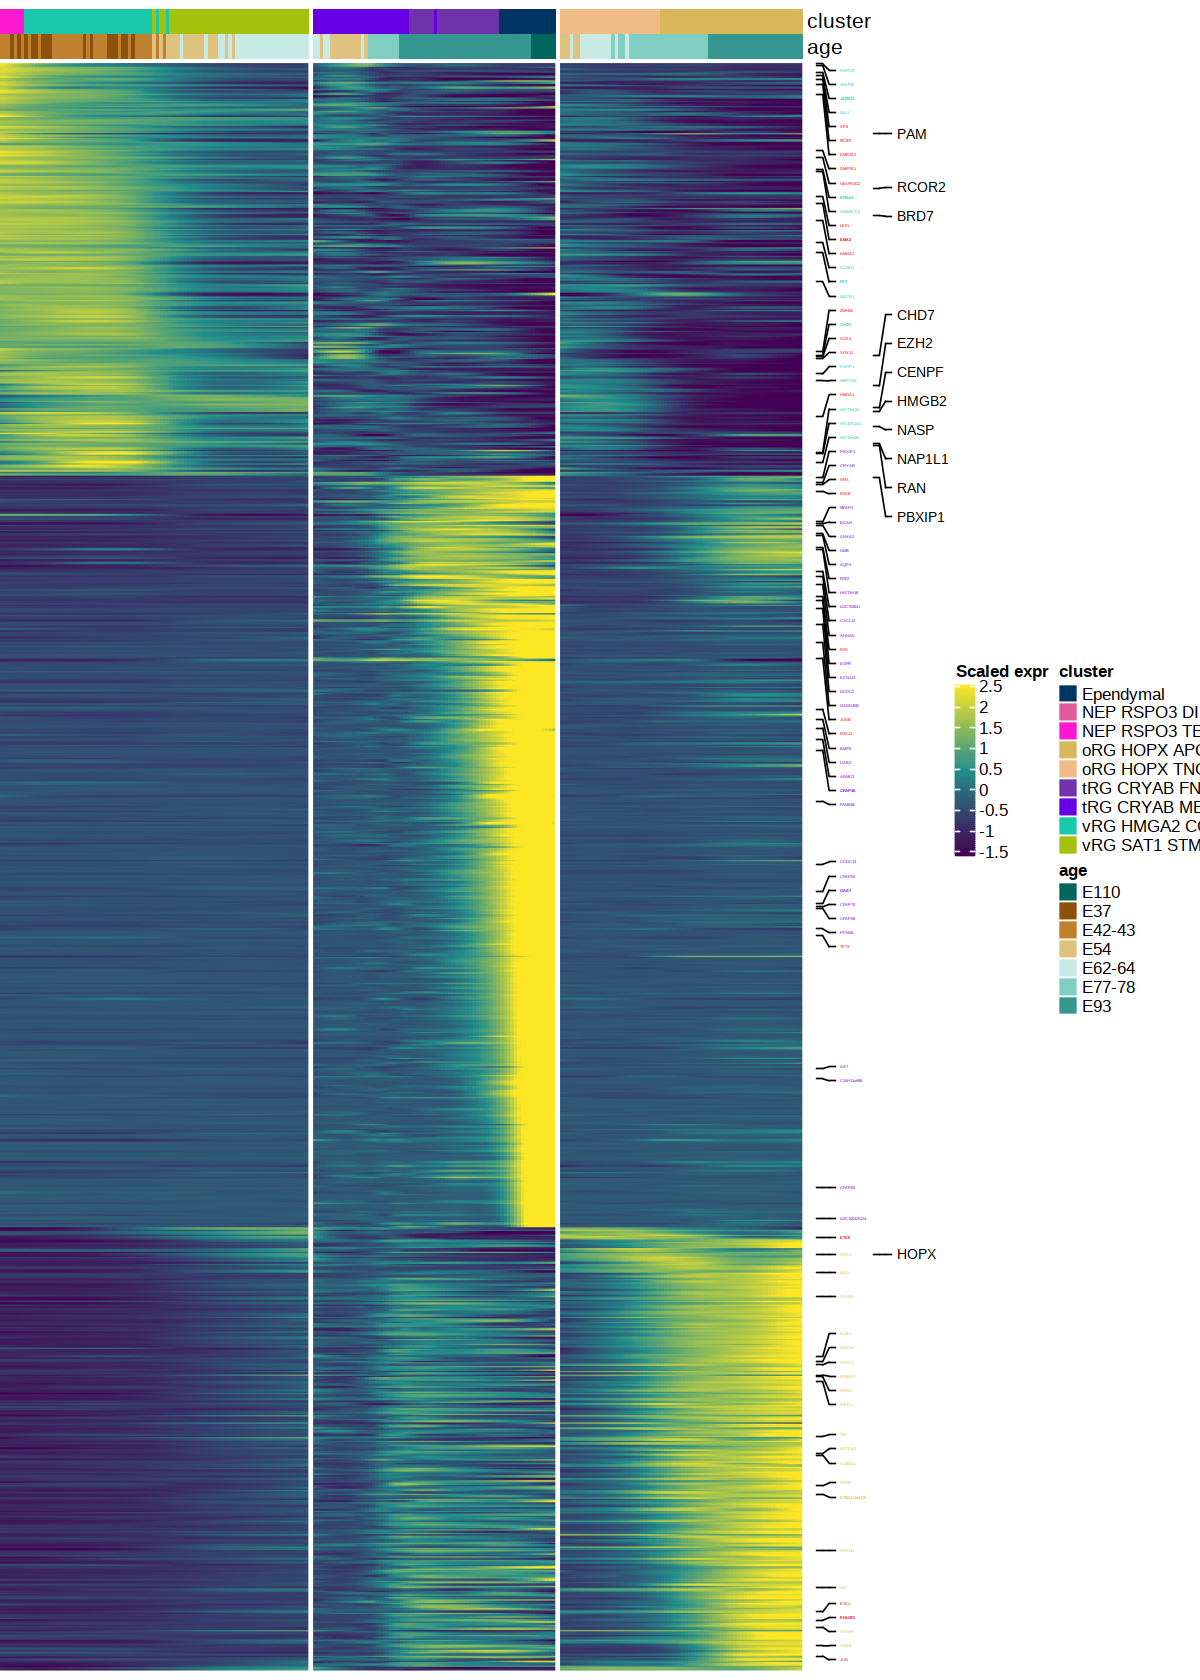

In [6]:
library(ComplexHeatmap)
fun1 <- colorRampPalette(viridis(3))##c("#FF00FF", "black", "#FFFF00")
color_breaks <- c(-1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5)
col_fun = circlize::colorRamp2(color_breaks, fun1(9))
column_ha <- HeatmapAnnotation(df = meta_use[, c("cluster", "age"), drop = FALSE], 
                               col = list(cluster = cls_cols, age = age_cols), 
                               annotation_height = unit(c(0.01, 0.01), "in"))
htlist <- Heatmap(pdata[allgenes, ], name = "Expression", 
        col = col_fun, na_col = "#FF00FF",
        column_split = factor(meta_use$lineage, levels = c("shared", "tRG", "oRG")),
        cluster_rows = FALSE, cluster_columns = FALSE, 
        row_title_rot = 90, column_title = NULL, row_title_gp = gpar(fontsize = 12), 
        show_column_names = FALSE, 
        show_row_names = FALSE, 
        column_names_gp = gpar(fontsize = 10),
        column_names_rot = 45, 
        width = unit(7, "in"),
        top_annotation = column_ha, 
        heatmap_legend_param = list(title = "Scaled expr", color_bar = "continuous", at = color_breaks),
        use_raster = TRUE, raster_quality = 3)
set.seed(0) 
label_genes <- sample(allgenes, 20) %>%
        c(., c("WNT7B","RSPO3", "JARID2", "DLL1","SP8", "FEZF2", 
               "DMRTA2", "DMRTA1", "NEUROG2","EFNA4","SMARCC1","LEF1",
               "EMX2", "FST","ZNF462","CHD7", "SOX4", "SOX11",
               "PARP1","PBXIP1", "CXCL12", "CRYAB", "NFIX", "FOSB", 
               "AQP4", "FGF2", "FOS", "EGFR", "KCNJ13", "GADD45B", 
               "JUNB", "FOXJ1", "BMP6", "DAB2", "TP73", "SRRY1", 
               "ETV5", "HOPX", "MGLL", "DAB1", "NRXN2", "SPRY2", 
               "FGFBP3", "FGFR1", "TNC", "NOTCH2", "S100A11", "NF1", 
               "ETV1", "POU2F1", "VEGFA", "JUN", "HMGA2","CCND1",
               "HMGA1","HIST1H1D", "HIST2H2AC", "HIST1H1B", 
               "HIST1H1E", "ANXA2", "BCAN","FAM81B", "CFAP45", 
               "CFAP65", "CFAP70", "CFAP69", "CFAP54")) %>%
        unique()
lab_cols <- rep("#1ac9a9", sum(rownames(pdata) %in% label_genes)) %>% 
            setNames(., rownames(pdata)[which(rownames(pdata) %in% label_genes)])
lab_cols[names(lab_cols) %in% pc_list$tRG] <- "#6700e5"
lab_cols[names(lab_cols) %in% pc_list$oRG] <- "#dbb75c"
lab_cols[names(lab_cols) %in% c("BCAN", "AQP4")] <- "#6700e5"
lab_cols[names(lab_cols) %in% tfs] <- "red"


htlist <- htlist + 
            HeatmapAnnotation(link = anno_mark(at = which(rownames(pdata) %in% label_genes), 
                                    labels = rownames(pdata)[which(rownames(pdata) %in% label_genes)], 
                                    side = "right",
                                    labels_gp = gpar(fontsize = 2, col = lab_cols, 
                                                     fontface = ifelse(rownames(pdata) %in% tfs, "bold", "plain")), 
                                               padding = unit(1, "mm")),
                                which = "row",
                                name = "custom")
htlist <- htlist + 
            HeatmapAnnotation(link = anno_mark(at = which(rownames(pdata) %in% chromatin), 
                                    labels = rownames(pdata)[which(rownames(pdata) %in% chromatin)], 
                                    side = "right",
                                    labels_gp = gpar(fontsize = 8, color = "red"), padding = unit(1, "mm")),
                                which = "row",
                                name = "non-TF ChrMM")
options(repr.plot.width=10, repr.plot.height=14, res = 600)
##pdf(paste0("./report/", "RGC_progression_cbn_shared_lev1_v2.pdf"), width = 14, height = 14)
draw(htlist)
##dev.off()

In [12]:
pdf(paste0("./report/", "RGC_progression_cbn_shared_lev1_v2.pdf"), width = 14, height = 14)
draw(htlist)
dev.off()

png 
  2

In [7]:
## -------------------------------------------------------------
## Gene Ontology of the shared genes


## Identify expressed genes
rgc_cbn$reg_cls <- paste0(rgc_cbn@meta.data$lobe, "|", rgc_cbn@meta.data$cluster)
all_cls <- levels(as.factor(rgc_cbn$reg_cls))
exp_ratio <- lapply(all_cls, function(x) {
    subseu <- subset(rgc_cbn, reg_cls == x)
    ratio <- setNames(Matrix::rowMeans(subseu$RNA@data != 0), rownames(rgc_cbn$RNA))
    ratio
    })%>%
        setNames(., all_cls) %>%
        as.data.frame(., check.names = FALSE) %>%
        as.matrix()
exp_genes <- rownames(exp_ratio)[apply(exp_ratio, 1, max) >= 0.1]
summary(exp_genes)

   Length     Class      Mode 
     9191 character character 

In [8]:
## Do the GeneOntology analysis
div_res <- list()
for (ii in names(pc_list)){
    div_res[[ii]] <- DoGO(all_genes = exp_genes, 
                          interesting_genes = pc_list[[ii]], 
                          pvalthre = 0.01, 
                          file_name = paste0("Enrich_sharedmars_", ii), 
                          output_dir = "./report/")
}


Building most specific GOs .....

	( 9335 GO terms found. )


Build GO DAG topology ..........

	( 13452 GO terms and 31602 relations. )


Annotating nodes ...............

	( 7814 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 3136 nontrivial nodes
		 parameters: 
			 test statistic: fisher


Building most specific GOs .....

	( 9335 GO terms found. )


Build GO DAG topology ..........

	( 13452 GO terms and 31602 relations. )


Annotating nodes ...............

	( 7814 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 3144 nontrivial nodes
		 parameters: 
			 test statistic: fisher


Building most specific GOs .....

	( 9335 GO terms found. )


Build GO DAG topology ..........

	( 13452 GO terms and 31602 relations. )


Annotating nodes ...............

	( 7814 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 3421 nontrivial nodes
		 parameters: 

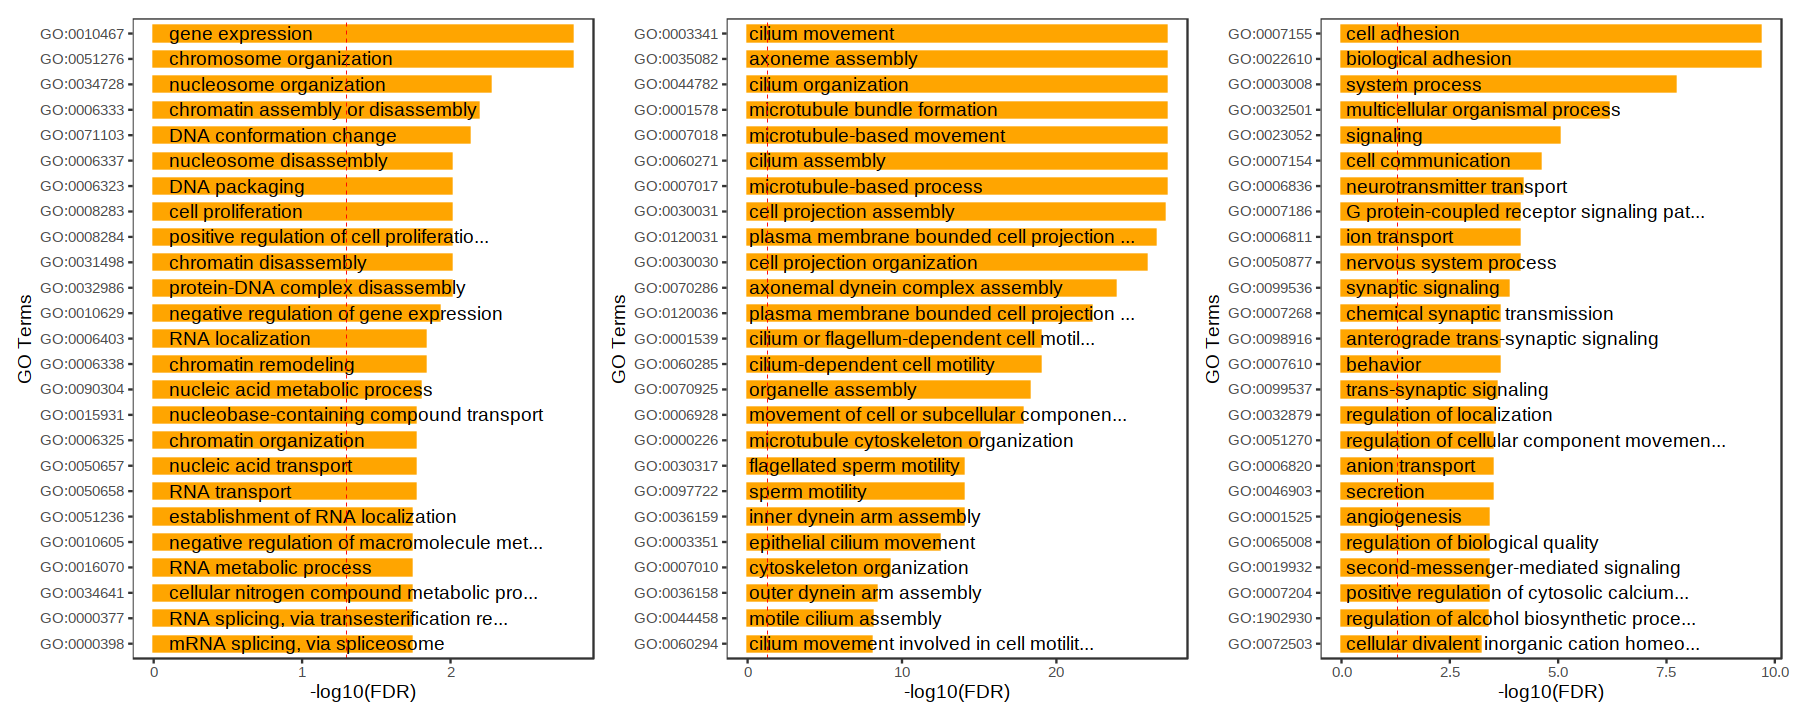

In [9]:
## visualize GO results
plist <- list()
for (ii in names(div_res)){
    pdata <- div_res[[ii]]$raw
    pdata$text_loc <- 0.1
    pdata$logfdr <- -log10(pdata$fdr)
    pdata <- pdata %>%
                filter(logfdr >= -log10(0.05))
    if (nrow(pdata) > 0){
        pdata <- pdata[1:min(25, nrow(pdata)), ]
        p <- ggplot(data = pdata) + 
            geom_bar(aes_string(x = "GO.ID", y = "logfdr"), 
                     color = "orange", fill = "orange", stat = "identity", width = 0.6) +
            xlim(limits = pdata[, "GO.ID"] %>% rev()) + 
            geom_text(aes_string(x = "GO.ID", y = "text_loc", label = "Term"), hjust = 0, size = 4) + 
            coord_flip() + 
            theme_bw() + 
            geom_hline(yintercept = -log10(0.05), size = 0.2, color = "red", linetype = "dashed")+
            theme(axis.text.y = element_text(size = rel(1)), 
                  panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank()) + 
            labs(y = "-log10(FDR)", x = "GO Terms")
        #pdf(paste0(outputdir, "Enrich_sharedmars_", ii, "_GO_correct.pdf"), width = 3, height = 3)
        #print(p)
        #dev.off()
        plist[[ii]] <- p
    }
}

pcbn <- patchwork::wrap_plots(plotlist = plist, nrow = 1, ncol = 3)
options(repr.plot.width=15, repr.plot.height=6, res = 600)
pcbn

In [10]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] org.Hs.eg.db_3.10.0   topGO_2.38.1          SparseM_1.78         
 [4] GO.db_3.10.0          AnnotationDbi_1.48.0  IRanges_2.20.2       
 [7] S4Vector